# Comparing performences of QSVM for different feature maps using the Iris Dataset

In [ ]:
!pip install -q qiskit
!pip install -q pennylane
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade imbalanced-learn


In [ ]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, BasicAer
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, AmplitudeEmbedding

import functools
from pennylane import numpy as np

### Description of the dataset

In [ ]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

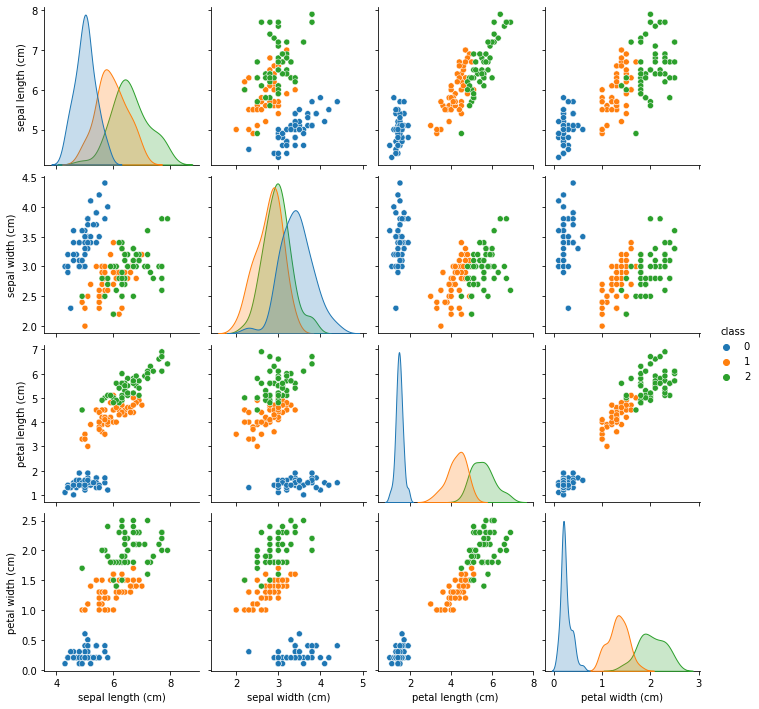

In [ ]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

Here we can see that Petal legth and width describes the difference better than Sepal length and width.

In [ ]:
features = MinMaxScaler().fit_transform(features)

X_reduced = PCA(2).fit_transform(features)
Xs = [features, features[:, 2:]   ,features[:,:2], X_reduced]
feature_type = ["All Features", "Petal Length & Width as Features", "Sepal Length & Width as Features", "Features reduced by PCA(2)"]

### Data Encoding using AngleEncoding

In [ ]:
def svm_with_angleEncoding(X,cv=2):
    n_qubits = len(X[0])
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    specs_func = qml.specs(kernel, expansion_strategy="device")
    depth = specs_func(X[0], X[0])["depth"]

    def kernel_matrix(A, B):
        """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
        return np.array([[kernel(a, b) for b in B] for a in A])

    svm = SVC(kernel=kernel_matrix, decision_function_shape="ovr")
    scores = cross_val_score(svm, X, labels, cv=cv)

    print( f"Accuracy with {n_qubits} qubits and depth of {depth}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")

# svm_with_angleEncoding(features,2)

In [ ]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:")
    svm_with_angleEncoding(X, 5)

For All Features:
Accuracy with 4 qubits and depth of 2: 0.96 with STD of 0.025. Accuracy Breakdown: [0.933, 0.967, 0.967, 0.933, 1.0]


For Petal Length & Width as Features:
Accuracy with 2 qubits and depth of 2: 0.96 with STD of 0.025. Accuracy Breakdown: [0.967, 0.967, 0.933, 0.933, 1.0]


For Sepal Length & Width as Features:
Accuracy with 2 qubits and depth of 2: 0.807 with STD of 0.074. Accuracy Breakdown: [0.7, 0.867, 0.733, 0.867, 0.867]


For Features reduced by PCA(2):
Accuracy with 2 qubits and depth of 2: 0.927 with STD of 0.033. Accuracy Breakdown: [0.9, 0.967, 0.9, 0.9, 0.967]




In [ ]:
def draw_angleEncoding_circuit(n_features=2):
    n_qubits = n_features
    dev_kernel = qml.device("default.qubit", wires=n_qubits)

    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

    print(f"Angle Encoding circuit for features length {n_qubits} using {n_qubits} qubits ")
    qml.draw_mpl(kernel, expansion_strategy="device")([np.random.rand() for _ in range(n_qubits)], [np.random.rand() for _ in range(n_qubits)])

Angle Encoding circuit for features length 2 using 2 qubits 


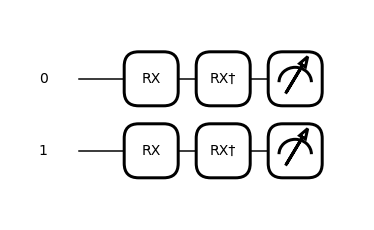

In [ ]:
draw_angleEncoding_circuit(2)

Angle Encoding circuit for features length 4 using 4 qubits 


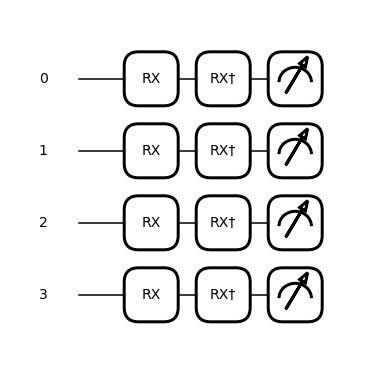

In [ ]:
draw_angleEncoding_circuit(4)

### Data Encoding using Amplitude Encoding

In [ ]:
def svm_with_amplitudeEncoding(X,cv=5):
    n_qubits = len(X[0]) // 2
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AmplitudeEmbedding(x1, wires=range(n_qubits), normalize = True)
        qml.adjoint(AmplitudeEmbedding)(x2, wires=range(n_qubits), normalize=True)
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

    specs_func = qml.specs(kernel, expansion_strategy="device")
    spec = specs_func(X[0], X[0])

    def kernel_matrix(A, B):
        """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
        return np.array([[kernel(a, b) for b in B] for a in A])

    svm = SVC(kernel=kernel_matrix, decision_function_shape="ovr")
    scores = cross_val_score(svm, X, labels, cv=cv)

    print( f"Accuracy with {n_qubits} qubits and depth of {spec['depth']}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")

# svm_with_amplitudeEncoding(features, 2)

In [ ]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:")
    svm_with_amplitudeEncoding(X, 5)


For All Features:
Accuracy with 2 qubits and depth of 5: 0.773 with STD of 0.102. Accuracy Breakdown: [0.7, 0.8, 0.8, 0.633, 0.933]


For Petal Length & Width as Features:
Accuracy with 1 qubits and depth of 2: 0.64 with STD of 0.053. Accuracy Breakdown: [0.567, 0.6, 0.7, 0.633, 0.7]


For Sepal Length & Width as Features:
Accuracy with 1 qubits and depth of 2: 0.7 with STD of 0.047. Accuracy Breakdown: [0.733, 0.667, 0.633, 0.7, 0.767]


For Features reduced by PCA(2):
Accuracy with 1 qubits and depth of 3: 0.58 with STD of 0.098. Accuracy Breakdown: [0.467, 0.6, 0.467, 0.667, 0.7]




In [ ]:
def draw_amplitudeEncoding_circuit(n_features):
    n_qubits = n_features // 2
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AmplitudeEmbedding(x1, wires=range(n_qubits), normalize = True)
        qml.adjoint(AmplitudeEmbedding)(x2, wires=range(n_qubits), normalize=True)
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

    print(f"Angle Amplitude circuit for features length of {n_features} using {n_qubits} qubits ")
    qml.draw_mpl(kernel, expansion_strategy="device")([np.random.rand() for _ in range(n_features)], [np.random.rand() for _ in range(n_features)])


Angle Amplitude circuit for features length of 2 using 1 qubits 


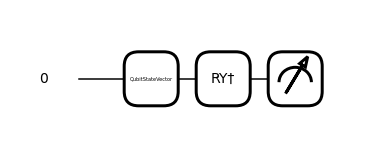

In [ ]:
draw_amplitudeEncoding_circuit(2)

Angle Amplitude circuit for features length of 4 using 2 qubits 


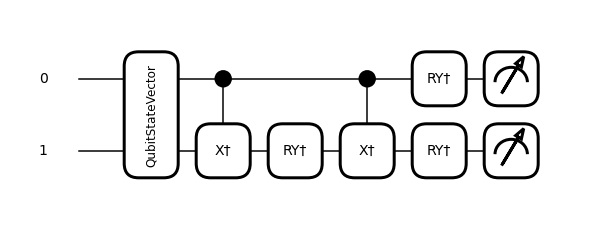

In [ ]:
draw_amplitudeEncoding_circuit(4)

### Data encoding using ZZFeatureMap

In [ ]:
def qsvm_with_zzfeaturemap(feature_dim, reps, X,cv=5):
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement='linear', insert_barriers=True)

    if reps == 1:
        display(feature_map.decompose().draw(output="mpl", fold=20))

    kernel = QuantumKernel(feature_map=feature_map,
                                 quantum_instance=BasicAer.get_backend(
                                                 'statevector_simulator'))
    # Set the SVC algorithm to use our custom kernel
    svc = SVC(kernel=kernel.evaluate, random_state= 42, decision_function_shape="ovr")  # using one-vs-all for multi-class classification



    scores = cross_val_score(svc, X, labels, cv=cv)
    print( f"Accuracy with {feature_dim} qubits, and depth of {feature_map.decompose().depth()}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")

    return scores.mean()

# qsvm_with_zzfeaturemap(4, 1, features, 5)

For All Features:


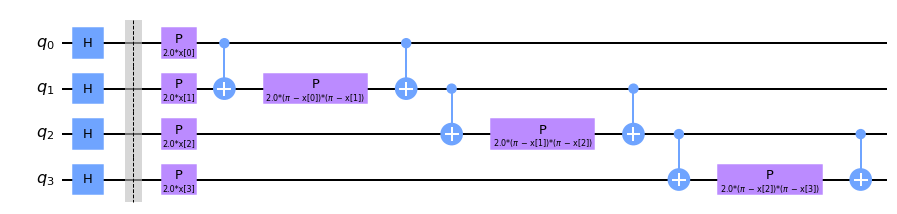

Accuracy with 4 qubits, and depth of 11: 0.967 with STD of 0.021. Accuracy Breakdown: [0.967, 0.967, 0.967, 0.933, 1.0]


For Petal Length & Width as Features:


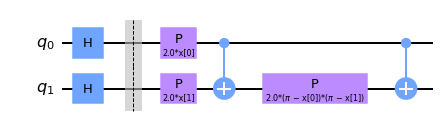

Accuracy with 2 qubits, and depth of 5: 0.96 with STD of 0.025. Accuracy Breakdown: [0.967, 0.967, 0.933, 0.933, 1.0]


For Sepal Length & Width as Features:


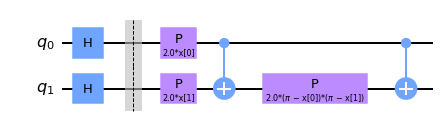

Accuracy with 2 qubits, and depth of 5: 0.8 with STD of 0.047. Accuracy Breakdown: [0.733, 0.833, 0.8, 0.767, 0.867]


For Features reduced by PCA(2):


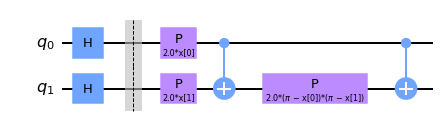

Accuracy with 2 qubits, and depth of 5: 0.92 with STD of 0.034. Accuracy Breakdown: [0.867, 0.933, 0.967, 0.9, 0.933]




In [ ]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:")
    score = qsvm_with_zzfeaturemap(feature_dim = len(X[0]), reps= 1,  X=X , cv =5) # ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


NB: Using multiple reps doesn't show meaningful improvemnt on result.

### Data encoding using ZFeatureMap

In [ ]:
def qsvm_with_zfeaturemap(feature_dim, reps, X,cv=5):
    feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=reps, insert_barriers=True)

    if reps == 1:
        display(feature_map.decompose().draw(output="mpl", fold=20))

    kernel = QuantumKernel(feature_map=feature_map,
                                 quantum_instance=BasicAer.get_backend(
                                                 'statevector_simulator'))
    # Set the SVC algorithm to use our custom kernel
    svc = SVC(kernel=kernel.evaluate, random_state= 42, decision_function_shape="ovr")  # using one-vs-all for multi-class classification



    scores = cross_val_score(svc, X, labels, cv=cv)
    print( f"Accuracy with {feature_dim} qubits, and depth of {feature_map.decompose().depth()}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")

    return scores.mean()

# qsvm_with_zzfeaturemap(4, 1, features, 5)

For All Features:


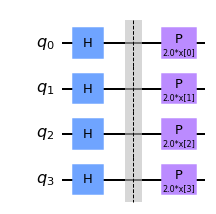

Accuracy with 4 qubits, and depth of 2: 0.967 with STD of 0.021. Accuracy Breakdown: [0.967, 0.967, 0.967, 0.933, 1.0]


For Petal Length & Width as Features:


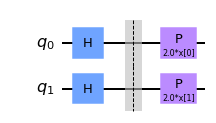

Accuracy with 2 qubits, and depth of 2: 0.953 with STD of 0.034. Accuracy Breakdown: [0.967, 0.967, 0.933, 0.9, 1.0]


For Sepal Length & Width as Features:


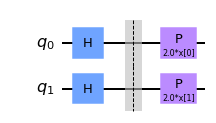

Accuracy with 2 qubits, and depth of 2: 0.807 with STD of 0.049. Accuracy Breakdown: [0.733, 0.833, 0.767, 0.833, 0.867]


For Features reduced by PCA(2):


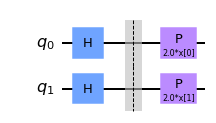

Accuracy with 2 qubits, and depth of 2: 0.953 with STD of 0.034. Accuracy Breakdown: [0.967, 1.0, 0.933, 0.9, 0.967]




In [ ]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:")
    score = qsvm_with_zfeaturemap(feature_dim = len(X[0]), reps= 1,  X=X , cv =5) # ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


### Classical SVC

In [ ]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:")


    svc = SVC()
    scores = cross_val_score(svc, X, labels, cv=10)
    print( f"\tAccuracy: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Acc Breakdown: {[round(num, 3) for num in scores]}")



For All Features:
	Accuracy: 0.96 with STD of 0.061. Acc Breakdown: [1.0, 0.933, 1.0, 1.0, 0.933, 0.933, 0.8, 1.0, 1.0, 1.0]
For Petal Length & Width as Features:
	Accuracy: 0.96 with STD of 0.044. Acc Breakdown: [1.0, 0.933, 1.0, 0.933, 0.933, 0.933, 0.867, 1.0, 1.0, 1.0]
For Sepal Length & Width as Features:
	Accuracy: 0.78 with STD of 0.085. Acc Breakdown: [0.667, 0.8, 0.867, 0.867, 0.667, 0.667, 0.867, 0.733, 0.8, 0.867]
For Features reduced by PCA(2):
	Accuracy: 0.953 with STD of 0.043. Acc Breakdown: [1.0, 0.933, 1.0, 0.933, 0.933, 0.933, 0.867, 0.933, 1.0, 1.0]
